In [1]:
# Standard library imports
import os
import logging
from typing import Tuple, List, Dict, Any

# Data processing imports
import numpy as np
import pandas as pd

# Machine learning imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# Deep learning imports
import torch
import torch.nn.functional as F
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sentence_transformers import SentenceTransformer

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Read the data

In [ ]:
def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """
    Load and preprocess the dataset.
    
    Args:
        file_path (str): Path to the CSV file
        
    Returns:
        pd.DataFrame: Preprocessed dataset
        
    Raises:
        FileNotFoundError: If the data file doesn't exist
        pd.errors.EmptyDataError: If the file is empty
    """
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Data file not found at: {file_path}")
        
        # Read CSV File
        data = pd.read_csv(file_path)
        
        if data.empty:
            raise pd.errors.EmptyDataError("The dataset is empty")
        
        # Lower Case all string values in the dataset
        data = data.applymap(lambda x: x.lower() if isinstance(x, str) else x)
        
        logger.info(f"Successfully loaded and preprocessed {len(data)} records")
        return data
        
    except Exception as e:
        logger.exeption(f"Error loading data: {str(e)}")
        raise

# Load and preprocess the data
try:
    data = load_and_preprocess_data('Raw_Data/pet-health-symptoms-dataset.csv')
    
    # Display basic information
    print("Dataset shape:", data.shape)
    print("\nColumns:", data.columns.tolist())
    print("\nSample counts by record type:")
    print(data['record_type'].value_counts())
    
except Exception as e:
    logger.exeption(f"Failed to load or process data: {str(e)}")
    raise

C:\Users\fhoss\AppData\Local\Temp\ipykernel_5240\3401015498.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x.lower() if isinstance(x, str) else x)
2025-09-12 17:13:16,630 - INFO - Successfully loaded and preprocessed 2000 records


Dataset shape: (2000, 3)

Columns: ['text', 'condition', 'record_type']

Sample counts by record type:
record_type
clinical notes       1000
owner observation    1000
Name: count, dtype: int64


In [ ]:
def split_data_by_type(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the data into clinical notes and owner observations.
    
    Args:
        data (pd.DataFrame): Input dataset
        
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Clinical notes and owner observations dataframes
    """
    try:
        data_clinic = data[data['record_type'] == 'clinical notes']
        data_owner = data[data['record_type'] == 'owner observation']
        
        if data_clinic.empty or data_owner.empty:
            raise ValueError("One or both of the split datasets are empty")
            
        logger.info(f"Split data into {len(data_clinic)} clinical notes and {len(data_owner)} owner observations")
        return data_clinic, data_owner
        
    except Exception as e:
        logger.exeption(f"Error splitting data: {str(e)}")
        raise

# Split the data
try:
    data_clinic, data_owner = split_data_by_type(data)
except Exception as e:
    logger.exeption(f"Failed to split data: {str(e)}")
    raise

2025-09-12 17:13:21,524 - INFO - Split data into 1000 clinical notes and 1000 owner observations


# Classification

In [ ]:
def encode_labels(data: pd.DataFrame, column: str) -> Tuple[pd.DataFrame, LabelEncoder]:
    """
    Encode category labels as numbers for model training.
    
    Args:
        data (pd.DataFrame): Input dataset
        column (str): Column name to encode
        
    Returns:
        Tuple[pd.DataFrame, LabelEncoder]: Updated dataframe and the encoder
    """
    try:
        label_encoder = LabelEncoder()
        data[f'{column}_encoded'] = label_encoder.fit_transform(data[column])
        
        # Display encoding mapping
        encoding_map = pd.DataFrame({
            'original': label_encoder.classes_,
            'encoded': range(len(label_encoder.classes_))
        })
        print("Label Encoding Map:")
        print(encoding_map)
        
        return data, label_encoder
        
    except Exception as e:
        logger.exeption(f"Error encoding labels: {str(e)}")
        raise

# Encode labels
try:
    data_owner, label_encoder = encode_labels(data_owner, 'condition')
    print("\nClass distribution:")
    print(data_owner.groupby(['condition_encoded', 'condition']).size())
except Exception as e:
    logger.exeption(f"Failed to encode labels: {str(e)}")
    raise

Label Encoding Map:
            original  encoded
0   digestive issues        0
1     ear infections        1
2  mobility problems        2
3          parasites        3
4   skin irritations        4

Class distribution:
condition_encoded  condition        
0                  digestive issues     200
1                  ear infections       200
2                  mobility problems    200
3                  parasites            200
4                  skin irritations     200
dtype: int64


C:\Users\fhoss\AppData\Local\Temp\ipykernel_5240\1921215948.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{column}_encoded'] = label_encoder.fit_transform(data[column])


In [ ]:
def prepare_train_val_split(
    data: pd.DataFrame,
    text_column: str,
    label_column: str,
    test_size: float = 0.2,
    random_state: int = 42
) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    """
    Split data into training and validation sets with stratification.
    
    Args:
        data (pd.DataFrame): Input dataset
        text_column (str): Name of the column containing text data
        label_column (str): Name of the column containing labels
        test_size (float): Proportion of data to use for validation
        random_state (int): Random seed for reproducibility
        
    Returns:
        Tuple containing train texts, validation texts, train labels, and validation labels
        
    Raises:
        ValueError: If input data is invalid or empty
    """
    try:
        if data.empty:
            raise ValueError("Input data is empty")
            
        if text_column not in data.columns or label_column not in data.columns:
            raise ValueError(f"Missing required columns. Need {text_column} and {label_column}")
            
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            data[text_column],
            data[label_column],
            stratify=data[label_column],
            test_size=test_size,
            random_state=random_state
        )
        
        logger.info(f"Split data into {len(train_texts)} training and {len(val_texts)} validation samples")
        return train_texts, val_texts, train_labels, val_labels
        
    except Exception as e:
        logger.exeption(f"Error in train-validation split: {str(e)}")
        raise

# Prepare train-validation split
try:
    train_texts, val_texts, train_labels, val_labels = prepare_train_val_split(
        data=data_owner,
        text_column='text',
        label_column='condition_encoded'
    )
except Exception as e:
    logger.exeption(f"Failed to split data into train-validation sets: {str(e)}")
    raise

2025-09-12 17:13:49,835 - INFO - Split data into 800 training and 200 validation samples


In [ ]:
class PetHealthDataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset for pet health text classification.
    
    Attributes:
        encodings: Tokenized and encoded text data
        labels: Encoded labels for classification
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """Get a single item from the dataset."""
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self) -> int:
        """Get the total size of the dataset."""
        return len(self.labels)

def prepare_model_inputs(
    train_texts: pd.Series,
    val_texts: pd.Series,
    train_labels: pd.Series,
    val_labels: pd.Series,
    model_name: str = "havocy28/VetBERTDx",
    max_length: int = 512
) -> Tuple[PetHealthDataset, PetHealthDataset, AutoTokenizer]:
    """
    Prepare model inputs by tokenizing texts and creating datasets.
    
    Args:
        train_texts: Training text data
        val_texts: Validation text data
        train_labels: Training labels
        val_labels: Validation labels
        model_name: Name of the pre-trained model to use
        max_length: Maximum sequence length for tokenization
        
    Returns:
        Tuple containing training dataset, validation dataset, and tokenizer
        
    Raises:
        RuntimeError: If tokenization or dataset creation fails
    """
    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        logger.info(f"Loaded tokenizer from {model_name}")
        
        # Tokenize texts
        train_encodings = tokenizer(
            list(train_texts),
            truncation=True,
            padding=True,
            max_length=max_length
        )
        val_encodings = tokenizer(
            list(val_texts),
            truncation=True,
            padding=True,
            max_length=max_length
        )
        
        # Convert labels to tensors
        train_labels = train_labels.reset_index(drop=True)
        val_labels = val_labels.reset_index(drop=True)
        train_labels_tensor = torch.tensor(train_labels.values).long()
        val_labels_tensor = torch.tensor(val_labels.values).long()
        
        # Create datasets
        train_dataset = PetHealthDataset(train_encodings, train_labels_tensor)
        val_dataset = PetHealthDataset(val_encodings, val_labels_tensor)
        
        logger.info("Successfully created training and validation datasets")
        return train_dataset, val_dataset, tokenizer
        
    except Exception as e:
        logger.exeption(f"Error preparing model inputs: {str(e)}")
        raise RuntimeError(f"Failed to prepare model inputs: {str(e)}")

# Prepare model inputs
try:
    train_dataset, val_dataset, tokenizer = prepare_model_inputs(
        train_texts=train_texts,
        val_texts=val_texts,
        train_labels=train_labels,
        val_labels=val_labels
    )
except Exception as e:
    logger.exeption(f"Failed to prepare model inputs: {str(e)}")
    raise

2025-09-12 17:14:12,617 - INFO - Loaded tokenizer from havocy28/VetBERTDx
2025-09-12 17:14:12,649 - INFO - Successfully created training and validation datasets


In [8]:
#Loging to Hugging face if you want to save the model in hugging face 
#Use the token for writing to save teh model in huging face
hf_token_write = "hf_token_write"

# In your notebook
from huggingface_hub import login
from HF_t import hf_token_write  # Import your token securely

login(token=hf_token_write)

In [9]:
# Define your metric computation function
model_name = "havocy28/VetBERTDx"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Define training arguments (don't use push_to_hub=True if you don't want to stor the model in Hugging face
training_args = TrainingArguments(
    output_dir='./model_calssification',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=20,
    eval_strategy="steps",  # Evaluate at fixed intervals
    eval_steps=50,                # Evaluate every 50 steps
    save_strategy="steps",
    save_steps=50,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    learning_rate=2e-5,
    lr_scheduler_type='linear',
    warmup_ratio=0.1,
    push_to_hub=True,
)
# # Add the EarlyStoppingCallback with patience and threshold
# early_stopping = EarlyStoppingCallback(
#     early_stopping_patience=3,             # Number of evaluations with no improvement to wait before stopping
#     early_stopping_threshold=0.0           # Minimum improvement to be considered (default is 0.0)
# )

from transformers import TrainerCallback

class StopAtStepCallback(TrainerCallback):
    def __init__(self, stop_step):
        self.stop_step = stop_step

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step >= self.stop_step:
            control.should_training_stop = True
        return control

# Use it in your Trainer
stop_callback = StopAtStepCallback(stop_step=301)
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  # Pass metric calculation function
    callbacks=[stop_callback]
)

# Start training
trainer.train()

c:\Users\fhoss\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251
c:\Users\fhoss\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,2.016500,1.610994,0.495000,0.541369,0.495000,0.408002
100,0.871500,0.696645,0.805000,0.803342,0.805000,0.801843
150,0.550200,0.581508,0.830000,0.835411,0.830000,0.827177
200,0.552600,0.474248,0.875000,0.875328,0.875000,0.873478
250,0.301000,0.492223,0.875000,0.877779,0.875000,0.872432
300,0.196700,0.425052,0.890000,0.891344,0.890000,0.888988


c:\Users\fhoss\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fhoss\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\fhoss\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\fhoss\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argum

TrainOutput(global_step=301, training_loss=1.1496917042522334, metrics={'train_runtime': 634.6254, 'train_samples_per_second': 6.303, 'train_steps_per_second': 0.788, 'total_flos': 33422092321968.0, 'train_loss': 1.1496917042522334, 'epoch': 3.01})

In [ ]:
#Push the tokenizer to the Hugging face 
repo_id = "fdastak/model_classification" 
tokenizer.push_to_hub(repo_id)

README.md: 0.00B [00:00, ?B/s]

c:\Users\fhoss\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\fhoss\.cache\huggingface\hub\models--fdastak--model_calssification. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
No files have been modified since last commit. Skipping to prevent empty commit.
2025

CommitInfo(commit_url='https://huggingface.co/fdastak/model_calssification/commit/5cce459c03f5331fd6c86bc6eb9fd6ede7772059', commit_message='Upload tokenizer', commit_description='', oid='5cce459c03f5331fd6c86bc6eb9fd6ede7772059', pr_url=None, repo_url=RepoUrl('https://huggingface.co/fdastak/model_calssification', endpoint='https://huggingface.co', repo_type='model', repo_id='fdastak/model_calssification'), pr_revision=None, pr_num=None)

In [ ]:
# Save teh model locally
# Suppose you have your Trainer instance named `trainer`
# trainer.save_model("./model/classification_ownernotes")
# tokenizer.save_pretrained("./model/classification_ownernotes")

('./model/classification_ownernotes_clean\\tokenizer_config.json',
 './model/classification_ownernotes_clean\\special_tokens_map.json',
 './model/classification_ownernotes_clean\\vocab.txt',
 './model/classification_ownernotes_clean\\added_tokens.json',
 './model/classification_ownernotes_clean\\tokenizer.json')

In [ ]:
#Load the model from local directory
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# model_path = "./model/classification_ownernotes"

# model = AutoModelForSequenceClassification.from_pretrained(model_path)
# tokenizer = AutoTokenizer.from_pretrained(model_path)  

#  Model Storage and Loading

To handle large model files efficiently:

1. The model files have been uploaded to Hugging Face's Model Hub
2. Instead of storing large model files in GitHub, we'll load the model directly from Hugging Face
3. Local model files are added to `.gitignore`

To use this model:
1. For training: The model will save locally in `./model/classification_ownernotes/`
2. For deployment: Load the model directly from Hugging Face (see next cell)

In [ ]:
#loading the model from hugging face
#Use the token for reading to load the model in huging face
hf_token_write = "hf_token_read"

# In your notebook
from huggingface_hub import login
from HF_t import hf_token_read  # Import your token securely

login(token=hf_token_read)

# Replace "your-username/my-awesome-fine-tuned-model" with your actual repository ID
repo_id = "fdastak/model_classification" 

# Load the fine-tuned model and its tokenizer
model = AutoModelForSequenceClassification.from_pretrained(repo_id)
tokenizer = AutoTokenizer.from_pretrained(repo_id)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

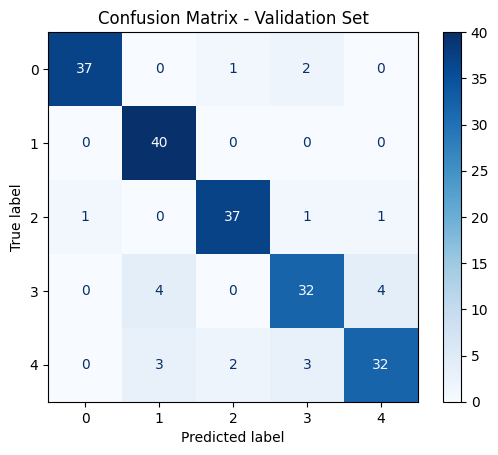

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch


# 1. Put your model in evaluation mode
model.eval()

# 2. Prepare lists to collect true labels and predictions
true_labels = []
pred_labels = []
pred_scores=[]

# 3. Disable gradient computation for inference
with torch.no_grad():
    for batch in val_dataset:
        # Move input tensors to model device if needed, e.g., batch['input_ids'].to(device)
        inputs = {k: v.unsqueeze(0) if v.dim() == 1 else v for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].unsqueeze(0)  # batch size 1
        # Remove token_type_ids if present
        if 'token_type_ids' in inputs:
           inputs.pop('token_type_ids')

        # Model prediction
        outputs = model(**inputs)
        logits = outputs.logits
        # Apply softmax to get probabilities over classes
        probs = F.softmax(logits, dim=-1)
        pred_score, pred_label = torch.max(probs, dim=1)

        true_labels.append(labels.item())
        pred_labels.append(pred_label.item())
        pred_scores.append(pred_score.item())  


# 4. Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# 5. Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [14]:
# Generate the classification report
from sklearn.metrics import classification_report
report = classification_report(true_labels, pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        40
           1       0.85      1.00      0.92        40
           2       0.93      0.93      0.93        40
           3       0.84      0.80      0.82        40
           4       0.86      0.80      0.83        40

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200

